Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


##### Basic stats about the data set w.r.t. drugs and diseases #####
Size of the data set: (215063, 6)
Number of unique drugs: 3671
Top 15 most frequent drugs (and their count): [('Levonorgestrel', 4930), ('Etonogestrel', 4421), ('Ethinyl estradiol / norethindrone', 3753), ('Nexplanon', 2892), ('Ethinyl estradiol / norgestimate', 2790), ('Ethinyl estradiol / levonorgestrel', 2503), ('Phentermine', 2085), ('Sertraline', 1868), ('Escitalopram', 1747), ('Mirena', 1673), ('Implanon', 1506), ('Gabapentin', 1415), ('Bupropion', 1369), ('Miconazole', 1344), ('Venlafaxine', 1338)]
Number of unique conditions: 917
Top 15 most frequent conditions (and their count): [('Birth Control', 38436), ('Depression', 12164), ('Pain', 8245), ('Anxiety', 7812), ('Acne', 7435), ('Bipolar Disorde', 5604), ('Insomnia', 4904), ('Weight Loss', 4857), ('Obesity', 4757), ('ADHD', 4509), ('Diabetes, Type 2', 3362), ('Emergency Contraception', 3290), ('High Blood Pressure', 3104), ('Vaginal Yeast Infection', 3085), (

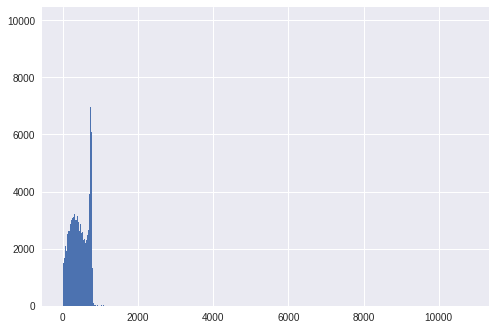

##### Basic stats about the training data set w.r.t. drugs and diseases #####
Size of the data set: (1604, 6)
Number of unique drugs: 75
Top 15 most frequent drugs (and their count): [('Lexapro', 62), ('Zoloft', 59), ('Cymbalta', 56), ('Mirena', 49), ('Belviq', 46), ('Chantix', 42), ('Pristiq', 41), ('Lyrica', 39), ('Suboxone', 37), ('Xanax', 33), ('Celexa', 33), ('Tramadol', 33), ('Contrave', 32), ('Prozac', 32), ('Klonopin', 31)]
Number of unique conditions: 47
Top 15 most frequent conditions (and their count): [('Depression', 246), ('Anxiety', 134), ('Bipolar Disorde', 123), ('Birth Control', 117), ('Pain', 83), ('Weight Loss', 79), ('Obesity', 67), ('ibromyalgia', 66), ('ADHD', 59), ('Insomnia', 57), ('Smoking Cessation', 42), ('Panic Disorde', 40), ('Anxiety and Stress', 39), ('Diabetes, Type 2', 39), ('Opiate Dependence', 37)]
Stats around number of characters in the data set
- Maximum number of characters in a drug review: 500
- Minimum number of characters in a drug review: 400

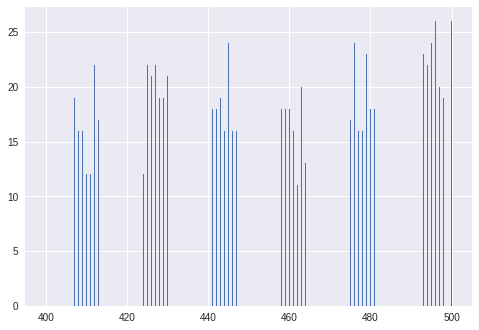

In [3]:
import numpy as np
import pandas as pd
from html import unescape
from matplotlib import pyplot as plt
from collections import Counter, defaultdict

from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
drive.mount('/content/gdrive')

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction

folder_dir = "/content/gdrive/My Drive/Exjobb/"
data_dir_drugs = folder_dir + "drugsCom_raw/"
baseline_dir = folder_dir + "baseline/"
sugg_dir = folder_dir + "suggested alternative/"
dong_dir = folder_dir + "dong_code/"
hu_dir = folder_dir + "hu_code/"

import sys
sys.path.insert(0, folder_dir + "keras_lstm_vae-master")
from lstm_vae.vae import create_lstm_vae

def print_data_stats(data, msg):
  print(msg)
  print("Size of the data set:", data.shape)
  print("Number of unique drugs:", len(set(data[:,0])))
  c_drug = Counter(data[:,0])
  print("Top 15 most frequent drugs (and their count):", c_drug.most_common(15))
  print("Number of unique conditions:", len(set(data[:,1])))
  c_cond = Counter(data[:,1])
  print("Top 15 most frequent conditions (and their count):", c_cond.most_common(15))  
  print("Stats around number of characters in the data set")
  lengths = [len(x) for x in data[:,2]]
  print("- Maximum number of characters in a drug review:", np.max(lengths))
  print("- Minimum number of characters in a drug review:", np.min(lengths))
  print("- Average number of characters in a drug review:", np.mean(lengths))
  print("- Standard deviation aruond number of characters in a drug review:", np.std(lengths))

training = np.array(pd.read_csv(data_dir_drugs + "drugsComTrain_raw.tsv", sep = "\t").fillna(-1))[:,1:]  # Remove the columns containing the indices for the drug reviews
testing = np.array(pd.read_csv(data_dir_drugs + "drugsComTest_raw.tsv", sep = "\t").fillna(-1))[:,1:]  # Remove the columns containing the indices for the drug reviews
data_before = np.vstack((training, testing))

print_data_stats(data_before, "##### Basic stats about the data set w.r.t. drugs and diseases #####")
plt.hist([len(x) for x in data_before[:,2]], 1000)
plt.show()

def is_valid(sample):
  no_parsing_error_or_empty = not "</span>" in sample[1] if isinstance(sample[1], str) else sample[1]!=-1
  if not no_parsing_error_or_empty:
    return False
  
  connected_with_review = sample[0].lower() in sample[2].lower() or sample[1].lower() in sample[2].lower() or "".join([x[0] for x in sample[1].split()]).lower() in sample[2].lower()
  if not connected_with_review:
    return False
  
  acceptable_size_of_drug_review = 400<=len(sample[2]) and len(sample[2])<=500
  if not acceptable_size_of_drug_review:
    return False
  
  satisfying_usefulcount_threshold = 10<=sample[5]
  if not satisfying_usefulcount_threshold:
    return False
  
  return True

def duplicate_free(data):
  present = defaultdict(lambda: (False, -1))
  new_data = []
  
  for entry in data:
    key = (entry[1], entry[2], entry[3])
    if (not present[key][0]) and entry[0] in entry[2]:
      new_data.append(entry)
      present[key] = (True, len(new_data) - 1)
    elif entry[0] in entry[2]:
      if new_data[present[key][1]][0] in entry[2]:
        new_data.append(entry)
      else:
        new_data[present[key][1]][0] = entry[0]
  
  return np.array(new_data)

def free_from_infrequents(data, min_count = 10):
  drug_counts = Counter(data[:,0])
  cond_counts = Counter(data[:,1])
  
  new_data = []
  for entry in data:
    if drug_counts[entry[0]]>=min_count and cond_counts[entry[1]]>=min_count:
      new_data.append(entry)
    
  return np.array(new_data)

training[:,2] = np.array([unescape(sample[1:-1]) for sample in training[:,2]])
training = free_from_infrequents(duplicate_free(np.array([sample for sample in training if is_valid(sample)])))
testing[:,2] = np.array([unescape(sample[1:-1]) for sample in testing[:,2]])
testing = free_from_infrequents(duplicate_free(np.array([sample for sample in testing if is_valid(sample)])))

print_data_stats(training, "##### Basic stats about the training data set w.r.t. drugs and diseases #####")
print(training, end = "\n\n")
print_data_stats(testing, "##### Basic stats about the testing data set w.r.t. drugs and diseases #####")
print(testing, end = "\n\n")

data_after = np.vstack((training, testing))
plt.hist([len(x) for x in data_after[:,2]], 1000)
plt.show()

In [24]:
##### Long Short-Term Memory network: The baseline model - Preparation: Training/optimizing of the Long Short-Term Memory network #####
def is_valid_for_baseline(sample, training = True):
  if training:
    return True
  else:
    return True

# Retrieve drug reviews from the data set
baseline_train = np.array([sample for sample in training if 
                           is_valid_for_baseline(sample)])[:,2]
baseline_test = np.array([sample for sample in testing if 
                          is_valid_for_baseline(sample, False)])[:,2]

class LSTM_model:
  def __init__(self, word_level = False, embedding_size = 100, num_units = 250, drop_out = 0.1):
    self.word_level = word_level
    self.tokenizer = Tokenizer(char_level = not self.word_level)
    self.max_sequence_len = None
    
    self.embedding_size = embedding_size
    self.num_units = num_units
    self.drop_out = drop_out
    self.model = None
  
  def __preprocess(self, train_data, verbose):
    if verbose:
      print("Preprocessing the data for the LSTM model...")

    self.tokenizer.fit_on_texts(train_data)
    num_tokens = len(self.tokenizer.word_index) + 1

    if verbose:
      print(num_tokens)

    input_sequences = []
    for review in train_data:
      token_list = self.tokenizer.texts_to_sequences([review])[0]
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i+1]
          input_sequences.append(n_gram_sequence)

    if verbose:
      print(len(input_sequences))
    
    self.max_sequence_len = max(len(x) for x in input_sequences)
    input_sequences = np.array(pad_sequences(input_sequences,
                                             maxlen = self.max_sequence_len, 
                                             padding='pre'))
    
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = ku.to_categorical(label, num_classes = num_tokens)
    
    return predictors, label
  
  def fit(self, train_data, num_epochs = 1, verbose = True, save = False):
    # Preparation of the data
    predictors, label = self.__preprocess(train_data, verbose)
    num_tokens = len(self.tokenizer.word_index) + 1
    
    if verbose:
      print("Done with preparing the data for the LSTM model!", end="\n\n")
    
    # Definition and training of the model
    if verbose:
      print("Training the LSTM model...")

    input_len = self.max_sequence_len - 1

    self.model = Sequential()
    self.model.add(Embedding(num_tokens, self.embedding_size, input_length=input_len))
    self.model.add(LSTM(self.num_units))
    self.model.add(Dropout(self.drop_out))
    self.model.add(Dense(num_tokens, activation='softmax'))

    self.model.compile(loss='categorical_crossentropy', optimizer='adam')
    self.model.fit(predictors, label, epochs = num_epochs, verbose = 1 if verbose else 0)
    
    if save:
      if verbose:
        print("Done with training the LSTM model!", end="\n\n")

      if verbose:
        print("Saving the model...")

      model_path = baseline_dir + "LSTM_" + ("word" if self.word_level else "char") + "_embedd-" + str(self.embedding_size) + "_units-" + str(self.num_units) + "_dropo-" + str(self.drop_out) + ".h5"
      self.model.save(model_path)

      if verbose and save:
        print("Model saved! It has the following path:", model_path)
  
  def generate(self, seed_text, next_tokens):
    for j in range(next_tokens):
      token_list = self.tokenizer.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen = self.max_sequence_len - 1, padding='pre')
      predicted = self.model.predict_classes(token_list, verbose=0)
      
      output_word = ""
      for word, index in self.tokenizer.word_index.items():
        if index == predicted:
          output_word = word
          break
        seed_text += (" " if self.word_level else "") + output_word
    
    return seed_text

print(baseline_train.shape)
# Example commands to both train- and run the above implementation
baseline_model = LSTM_model(word_level = False, embedding_size = 500, num_units = 750, drop_out = 0)
baseline_model.fit(baseline_train, 1)
review = np.random.choice(baseline_train)
print(review)
print(baseline_model.generate(review[:15], len(review[15:])))

(1604,)
Preprocessing the data for the LSTM model...
69
723548
Done with preparing the data for the LSTM model!

Training the LSTM model...
Epoch 1/1
   352/723548 [..............................] - ETA: 14:09:29 - loss: 3.8911

KeyboardInterrupt: ignored

In [32]:
##### SUGGESTED ALTERNATIVE - Preparation: Training/optimizing of the recurrent variational autoencoder #####
def is_valid_for_suggestion(sample, training = True):
  if training:
    return True
  else:
    return True

sugg_train = np.array([sample for sample in training if is_valid_for_suggestion(sample)])[:,:-2]
sugg_test = np.array([sample for sample in testing if is_valid_for_suggestion(sample, False)])[:,:-2]

class suggested_alternative:
  def __init__(self, word_level = False):
    self.word_level = word_level
    self.tokenizer = Tokenizer(char_level = not self.word_level)
    self.max_sequence_len = None
    
    # Settings for the recurrent variational autoencoder
    self.encoder = None
    self.decoder = None
    
    # Settings for the collaborative filtering algorithm
    self.cf = None
    
  def __preprocess(self, train_data, verbose = True):
    if verbose:
      print("Preprocessing the data for the LSTM model...")
    
    self.tokenizer.fit_on_texts(train_data)
    num_tokens = len(self.tokenizer.word_index) + 1
    
    if verbose:
      print(num_tokens)
    
    input_sequences = []
    for review in train_data:
      input_sequence = []
      token_list = self.tokenizer.texts_to_sequences([review])[0]
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i+1]
          input_sequence.append(n_gram_sequence)
      input_sequences.append(input_sequence)
    
    if verbose:
      print(len(input_sequences))
    
    self.max_sequence_len = max(len(input_seq) for input_seq in input_sequences)
    input_sequences = np.array(pad_sequences([pad_sequences(input_seq,
                                             maxlen = self.max_sequence_len,
                                             padding='pre') for input_seq in input_sequences], 
                                             maxlen = self.max_sequence_len,
                                             padding='pre'))
    
    return input_sequences
  
  def fit(self, train_data, verbose = True):
    # One-hot encoding of both the drugs and conditions associated with the reviews
    """onehot_drugs = OneHotEncoder().fit_transform(train_data[:,0].reshape(-1, 1))
    onehot_conds = OneHotEncoder().fit_transform(train_data[:,1].reshape(-1, 1))"""
    
    # Transforming the review texts into latent numericals vectors
    self.__fit_lstm(self.__preprocess(train_data[:,2]))
    self.encoder = Model()
  
  def __fit_lstm(self, train_data):
    print(train_data.shape)
    lstm_vae, _, _ = create_lstm_vae(train_data.shape[-1], train_data.shape[1], 32, 250, 1)
    lstm_vae.summary()
    lstm_vae.fit(train_data)
  
  def __fit_cf(self, train_data):
    return train_data
    
  def generate(self, x):
    return x

print(sugg_train.shape)
# Example commands to both train- and run the above implementation
suggested_model = suggested_alternative(True)
suggested_model.fit(sugg_train)
review = np.random.choice(sugg_train)
print(review)
print(sugg_model.generate(review[:15], len(review[15:])))

(1604, 4)
Preprocessing the data for the LSTM model...
6679
1604
(1604, 110, 110)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 110, 110)     0                                            
__________________________________________________________________________________________________
lstm_43 (LSTM)                  (None, 250)          361000      input_27[0][0]                   
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1)            251         lstm_43[0][0]                    
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 1)            251         lstm_43[0][0]                    
___________________________

IndexError: ignored

In [0]:
##### MODEL PROPOSED BY DONG ET AL. - Preparation: Training/optimizing of the model proposed by Dong et al. #####
def is_valid_for_dong(sample, training = True):
  if training:
    return True
  else:
    return True

class dong_model:
  def __init__(self):
    pass
  
  def fit(self, train_data):
    pass
  
  def generate(self, x):
    return x

# TROLOLOLOLOL...


In [0]:
##### MODEL PROPOSED BY HU ET AL. - Preparation: Training/optimizing of the model proposed by Hu et al. #####
def is_valid_for_hu(sample, training = True):
  if training:
    return True
  else:
    return True

class hu_model:
  def __init__(self):
    pass
  
  def fit(self, train_data):
    return train_data
  
  def generate(self, x):
    return x
  
# TROLOLOLOLOL...


In [64]:
##### THE FINAL RUMLBE EXPERIMENT - The killer moment! #####

def get_bleu_score(review, test_data, rating_span = 5):
  try:
    candidate = review[2].lower().split()
    references = [ref_review[2].lower().split() for ref_review in test_data if (ref_review[[1,3]]==review[[1,3]]).all()]
    return bleu(references, candidate, smoothing_function = SmoothingFunction().method4)
  except KeyError as e:
    print("WARNING: No reference translations were obtainable for the following review:")
    print(review)
    return -1

# TODO
i = np.random.randint(testing.shape[0])
print(get_bleu_score(testing[i], testing[[j for j in range(testing.shape[0]) if j!=i]]))

# ROFLOLOLOLOLOLOLOL...


0.11957185526971167
